<a href="https://colab.research.google.com/github/jacob-danner/machine-learning-experiments/blob/main/MINST_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import torch
import torch.nn as nn
from torch import Tensor, tensor

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from PIL import Image

In [65]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('GPU is not available, using the CPU instead.')

GPU is not available, using the CPU instead.


## Utils

In [66]:
to_img = transforms.ToPILImage()

def display_tensor_as_image(tensor: Tensor):
    tensor = tensor.view(28, 28)
    img: Image.Image = to_img(tensor)
    img = img.resize((28*4, 28*4))
    display(img)

## Dataset and DataLoader

In [67]:
# transforms

class FlattenImage():
    def __call__(self, x):
        return x.view(28*28)

transforms = transforms.Compose([
    transforms.ToTensor(),
    FlattenImage()
])


ex_input.shape: torch.Size([784])


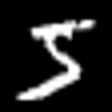

In [68]:
class AutoencoderMNISTDataset(Dataset):
    '''
    This dataset class uses the default MNIST dataset, but replaces the digit labels (eg: 8) with the input.

    original dataset: (input, label)
    desired dataset:  (input, input)

    This transformation of the labels is done to reflect the nature of an autoencoder model.
    An autoencoder is meant to reconstruct the input, not classify it. Therefore label == input
    '''
    def __init__(self):
        self.mnist = datasets.MNIST(root='./data', train=True, transform=transforms, download=True)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, index):
        row = self.mnist[index]
        img, _ = row # throw away the digit label
        return img, img

autoencoder_mnist_dataset = AutoencoderMNISTDataset()
autoencoder_mnist_loader = DataLoader(dataset=autoencoder_mnist_dataset, batch_size=64, shuffle=True)

ex_mnist_row = autoencoder_mnist_dataset[0]
ex_input, ex_label = ex_mnist_row
assert torch.equal(ex_input, ex_label)

print(f'ex_input.shape: {ex_input.shape}')
display_tensor_as_image(ex_input)

## Model Architecture

In [69]:
class AutoEncoder(nn.Module):
    def __init__(self):
        '''
        This model's input layer is 784 nodes.
        784 = 28 * 28 image flattened to 1 dimension.

        The encoder's hidden layers reduce the dimensionality of the encoder's input

        The decoder's hidden layers increase the dimensionality of decoder's input to the original 784.
        '''
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 98),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(98, 784),
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.sigmoid(x)
        return x

In [70]:
# Loss function

def reconstruction_loss_fn(reconstruction, original):
    '''
    compare the difference between the reconstruction and original using MSELoss

	reconstruction has shape (n, 784)
	original has shape (n, 784)
    '''

    criterion = nn.MSELoss()
    loss = criterion(reconstruction, original)
    return(loss)

assert reconstruction_loss_fn(ex_input, ex_input) == tensor(0.) # reconstruction loss comparing two identical images should be 0

## Model Training

### Learning Rate Finder

In [ ]:
!pip install torch-lr-finder
from torch_lr_finder import LRFinder

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.11E+00


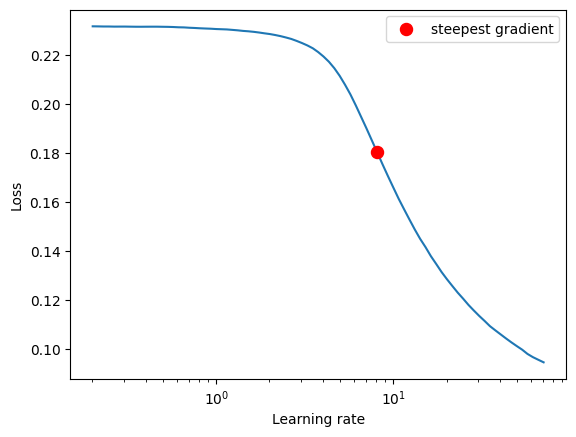

In [72]:
model = AutoEncoder()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
lr_finder = LRFinder(model, optimizer, reconstruction_loss_fn, device=device)
lr_finder.range_test(autoencoder_mnist_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

### Training Loop

In [73]:
def train_one_epoch(model, optimizer, reconstruction_loss_fn, data_loader):
    epoch_running_loss = 0

    for i, batch in enumerate(data_loader):
        inputs, labels = batch # note that inputs == labels, because the data_loader was designed for an autoencoder

        inputs = inputs.to(device) #  move to GPU if available

        optimizer.zero_grad() # zero gradients

        reconstructions = model(inputs)

        # compute loss and gradients
        reconstruction_loss = reconstruction_loss_fn(reconstructions, labels)
        reconstruction_loss.backward()

        # step the weights
        optimizer.step()

        epoch_running_loss += reconstruction_loss.item()

    epoch_average_loss = epoch_running_loss / len(data_loader)

    return epoch_average_loss

In [74]:
# TRAIN FOR N_EPOCHS

model = AutoEncoder()
optimizer = torch.optim.SGD(model.parameters(), lr=8.11E+00)

model.to(device)

N_EPOCHS = 20

model.train()

for i in range(N_EPOCHS):
    epoch_average_loss = train_one_epoch(model, optimizer, reconstruction_loss_fn, autoencoder_mnist_loader)
    print(f'epoch #{i}: epoch_average_loss = {epoch_average_loss}')

epoch #0: epoch_average_loss = 0.0418249223647373
epoch #1: epoch_average_loss = 0.01936301050473378
epoch #2: epoch_average_loss = 0.012838769341701828
epoch #3: epoch_average_loss = 0.009954435339292833
epoch #4: epoch_average_loss = 0.008421448218737488
epoch #5: epoch_average_loss = 0.007435268838145236
epoch #6: epoch_average_loss = 0.006728270253452506
epoch #7: epoch_average_loss = 0.006188600445722244
epoch #8: epoch_average_loss = 0.0057650544925896665
epoch #9: epoch_average_loss = 0.005425435471793276
epoch #10: epoch_average_loss = 0.00514384309377974
epoch #11: epoch_average_loss = 0.0049053372985034035
epoch #12: epoch_average_loss = 0.004698431411478072
epoch #13: epoch_average_loss = 0.004516744733736444
epoch #14: epoch_average_loss = 0.004355967137664715
epoch #15: epoch_average_loss = 0.0042124446702382365
epoch #16: epoch_average_loss = 0.00408361964736944
epoch #17: epoch_average_loss = 0.003972749812836284
epoch #18: epoch_average_loss = 0.0038760936320590567
epoc

In [76]:
torch.save(model.state_dict(), 'mnist-autoencoder.pt')

original:


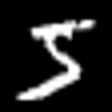

reconstructed:


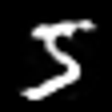


original:


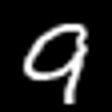

reconstructed:


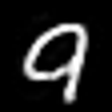


original:


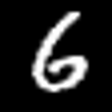

reconstructed:


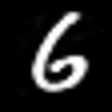


original:


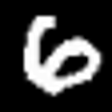

reconstructed:


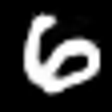


original:


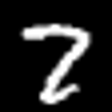

reconstructed:


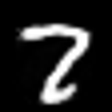


original:


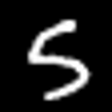

reconstructed:


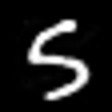


original:


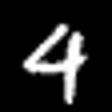

reconstructed:


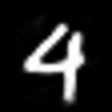


original:


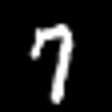

reconstructed:


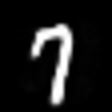


original:


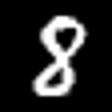

reconstructed:


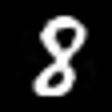


original:


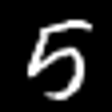

reconstructed:


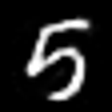


original:


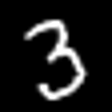

reconstructed:


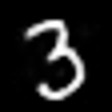


original:


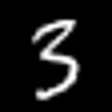

reconstructed:


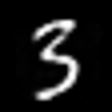


original:


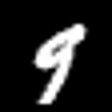

reconstructed:


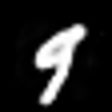


original:


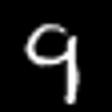

reconstructed:


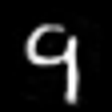


original:


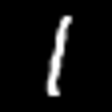

reconstructed:


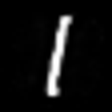


original:


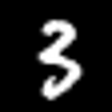

reconstructed:


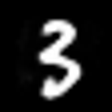


original:


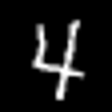

reconstructed:


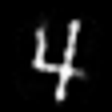


original:


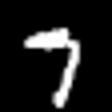

reconstructed:


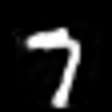


original:


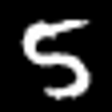

reconstructed:


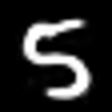


original:


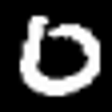

reconstructed:


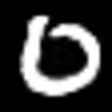

In [75]:
def display_original_and_reconstructed(original: Tensor):
    print('original:')
    display_tensor_as_image(original)

    original = original.to(device)
    reconstructed = model(original).view(28, 28)

    print('reconstructed:')
    display_tensor_as_image(reconstructed)

    print()

# show 20 examples
for i in range(len(autoencoder_mnist_dataset))[0 : -1 : 3000]:
    display_original_and_reconstructed(autoencoder_mnist_dataset[i][0])
